In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from gensim import parsing
import glob
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords 
from tqdm import tqdm

<h2> 20NG </h2>

In [2]:
news_group = fetch_20newsgroups( subset = 'train' , remove =  ("headers", "footers" ))

In [3]:
newsDF = pd.DataFrame({"news" : news_group.data ,"class" : news_group.target })

<h4>Cleaning the Text for 20NG</h4>

In [4]:
transform_to_lower = lambda s: s.lower()
remove_emails = lambda s: re.sub(r'^[a-zA-Z0-9+_.-]+@[a-zA-Z0-9.-]+$', '', s)
remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s)

CLEAN_FILTERS = [
                remove_emails,
                strip_tags,
                strip_numeric,
                remove_emails,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords]

def cleaningPipe(document):
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words

def joinList(processed_words):
    return ' '.join(processed_words)

def basicStemming(text):
    return parsing.stem_text(text)

In [5]:
newsDF["cleanedText"] = newsDF["news"].apply(cleaningPipe).apply(joinList).apply(basicStemming)

In [6]:
newsDF = newsDF[:1000]

In [7]:
tf_vectorizer = CountVectorizer(stop_words = 'english')

In [8]:
tf = tf_vectorizer.fit_transform(newsDF["cleanedText"])

In [9]:
vocabulary = tf_vectorizer.vocabulary_

In [10]:
docs = []
for row in tf.toarray():
    present_words = np.where(row != 0)[0].tolist()
    present_words_with_count = []
    for word_idx in present_words:
        for count in range(row[word_idx]):
            present_words_with_count.append(word_idx)
    docs.append(present_words_with_count)

In [11]:
D = len(docs)        # number of documents
V = len(vocabulary)  # size of the vocabulary 
T = 20               # number of topics
iterations = 100   # number of iterations

alpha = 1 / T         # the parameter of the Dirichlet prior on the per-document topic distributions
beta = 1 / T        # the parameter of the Dirichlet prior on the per-topic word distribution

In [12]:
z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j
theta_d_z = np.zeros((D, T))
phi_z_w = np.zeros((T, V))
n_d = np.zeros((D))
n_z = np.zeros((T))

## Initialize the parameters
# m: doc id
for d, doc in enumerate(docs):
    # n: id of word inside document, w: id of the word globally
    for n, w in enumerate(doc):
        # assign a topic randomly to words
        z_d_n[d][n] = n % T
        # get the topic for word n in document m
        z = z_d_n[d][n]
        # keep track of our counts
        theta_d_z[d][z] += 1
        phi_z_w[z, w] += 1
        n_z[z] += 1
        n_d[d] += 1

for iteration in tqdm(range(iterations)):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word n in document m
            z = z_d_n[d][n]

            # decrement counts for word w with associated topic z
            theta_d_z[d][z] -= 1
            phi_z_w[z, w] -= 1
            n_z[z] -= 1

            # sample new topic from a multinomial according to our formula
            p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + T * alpha)
            p_t_w = (phi_z_w[:, w] + beta) / (n_z + V * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            new_z = np.random.multinomial(1, p_z).argmax()

            # set z as the new topic and increment counts
            z_d_n[d][n] = new_z
            theta_d_z[d][new_z] += 1
            phi_z_w[new_z, w] += 1
            n_z[new_z] += 1

100%|██████████| 100/100 [07:24<00:00,  4.45s/it]


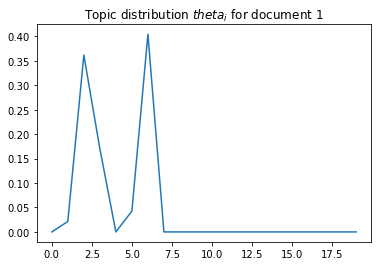

In [13]:
i = 1
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]));
plt.title("Topic distribution $theta_i$ for document {}".format(i));

In [14]:
phi_z_w.shape

(20, 15720)

In [15]:
inv_vocabulary = {v: k for k, v in vocabulary.items()}
n_top_words = 20
for topic_idx, topic in enumerate(phi_z_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: car speed look rate year drive engin insur driver write articl bui mile mhz model hp new ve time ticket
Topic #1: argument exampl conclus fallaci claim post evid gener mean event premis discuss ad homosexu sex reason occur book form exist
Topic #2: window file problem write run program thank work like card mb disk softwar pc ve help memori know edu control
Topic #3: space power applic nasa select astronaut requir design flight year program level station cost experi refer work degre follow mission
Topic #4: write like know think articl peopl time thing wai want com right good mean edu come sai question point reason
Topic #5: good orbit space launch excel earth shuttl modul nasa miss cover mission tn dr includ fair geoffrei uccxkvb moon probe
Topic #6: com new thank sale cabl ask articl offer edu price need bike write brake exhaust pressur sound dai appl oil
Topic #7: water doctor effect treatment articl caus yeast problem pain patient test help food know medic drug cool usual 

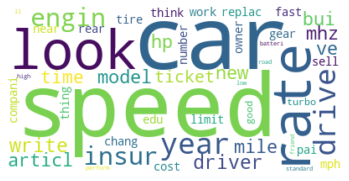

car speed look rate year drive engin insur driver write articl bui mile mhz model hp new ve time ticket replac owner think compani cost fast tire gear chang mph pai limit thing work edu near rear sell number turbo like good perform ll road friend batteri high low standard


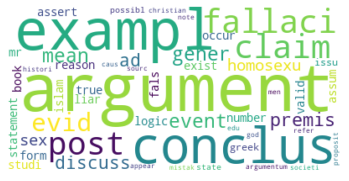

argument exampl conclus fallaci claim post evid gener mean event premis discuss ad homosexu sex reason occur book form exist mr true logic number statement assert fals studi islam valid assum liar greek issu possibl state argumentum mistak societi histori god christian caus refer appear note men edu proposit sourc


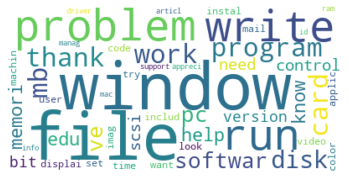

window file problem write run program thank work like card mb disk softwar pc ve help memori know edu control need scsi version bit displai want time color set includ applic mail look try imag user machin instal video code appreci mac articl id manag driver ram com info support


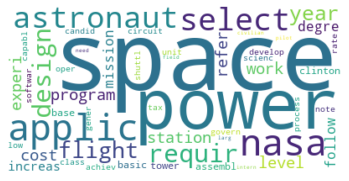

space power applic nasa select astronaut requir design flight year program level station cost experi refer work degre follow mission increas assembl tower clinton basic base develop circuit oper class govern capabl unit note gener process candid softwar tax scienc rate low achiev shuttl civilian field larg need intern pilot


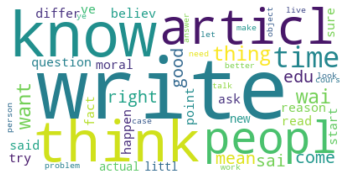

write like know think articl peopl time thing wai want com right good mean edu come sai question point reason said believ differ happen moral try ve read start ask fact sure littl new actual problem better person need make talk look let answer cours object live ye work case


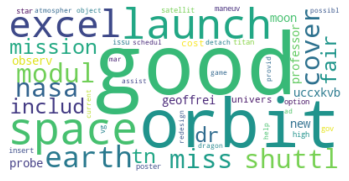

good orbit space launch excel earth shuttl modul nasa miss cover mission tn dr includ fair geoffrei uccxkvb moon probe observ professor new univers cost option satellit high issu insert vg gov titan maneuv star poster atmospher help schedul dragon possibl ad object mar assist provid detach current game redesign


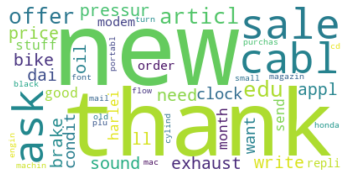

com new thank sale cabl ask articl offer edu price need bike write brake exhaust pressur sound dai appl oil ll clock condit want stuff good month harlei send order modem repli magazin old like purchas mac small font mail machin cd portabl honda cylind plu flow engin black turn


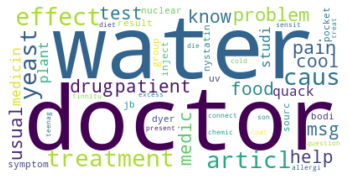

water doctor effect treatment articl caus yeast problem pain patient test help food know medic drug cool usual msg quack medicin studi plant symptom sourc dyer group result inject nystatin pocket nuclear jb uv bodi question chemic present cold sensit son die diet connect excess treat allergi teenag tinnitu coat


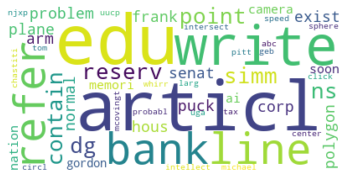

edu articl write line bank refer point dg reserv simm ns contain problem exist polygon plane senat hous corp normal puck arm frank memori ai camera soon nation gordon probabl michael intersect uga larg abc tax speed pitt geb center sphere intellect click uucp tom chastiti whirr circl mcovingt njxp


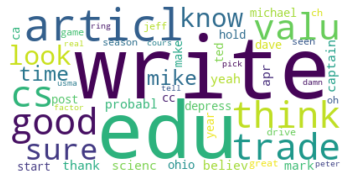

write edu articl think trade cs good valu sure look know mike time probabl yeah scienc mark believ apr thank captain depress michael ted start post hold dave ohio ca year cc make great ch jeff oh drive seen season game peter usma damn pick factor real cours ring tell


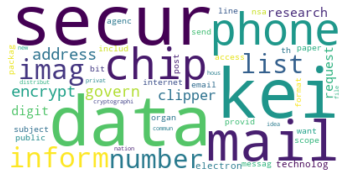

kei data secur mail phone chip inform imag number list encrypt address govern clipper research digit request technolog com electron subject bit public includ agenc provid want send email th messag line format access post scope organ nsa internet paper packag cryptographi nation idea new privat hous distribut file commun


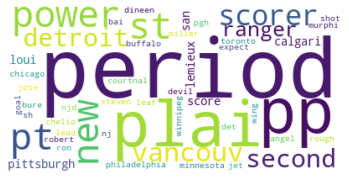

period plai pp power new pt st scorer vancouv detroit second ranger pittsburgh score lemieux loui san calgari philadelphia buffalo njd toronto chicago leaf jose dineen goal lead minnesota rough devil bai pgh steven jet shot nj angel expect wing courtnal murphi sh miller winnipeg det bure ron robert chelio


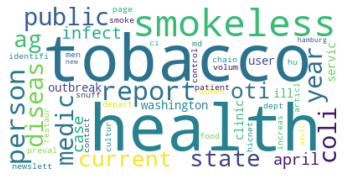

health tobacco smokeless report person public medic year diseas coli state ag current oti infect april case washington user servic ill outbreak clinic patient preval md depart newslett ci men page identifi women restaur chain smoke volum hu dept articl contact control increas food hicnet cultur snuff hamburg adult new


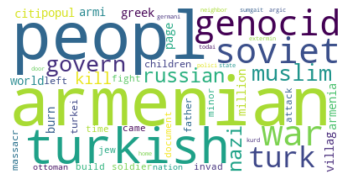

armenian peopl turkish genocid war soviet turk govern muslim russian nazi kill greek armi citi villag burn popul million page world armenia children massacr turkei father left soldier time document build fight jew invad minor came attack ottoman nation sumgait door argic neighbor extermin kurd home germani state todai polici


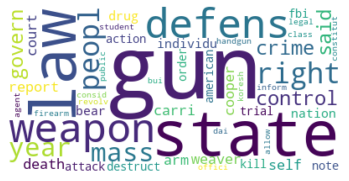

gun state law weapon defens right peopl year mass control said crime govern report death carri cooper arm weaver self court individu bear drug nation destruct action kill american note fbi trial attack order student agent class firearm bui handgun consid dai inform legal offici constitut public revolv allow koresh


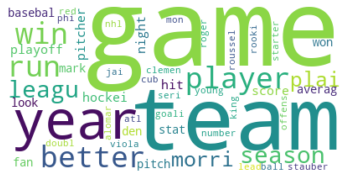

game team year player win run better season leagu plai morri playoff hockei hit pitcher score night pitch averag basebal look fan stat den won mark young goali viola stauber clemen number red mon cub lead nhl doubl starter ball jai seri rooki roussel offens roger king alomar phi atl


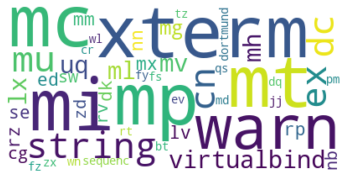

xterm mp mt mi mc warn string mu ex dc cn virtualbind uq mv ml mh lx mg rp lv mm se rz mx dk ed nn cg sw nb zd rv sequenc pm dortmund jj zx wl cr ev tz md qs wn bt fz fy dq rt fs


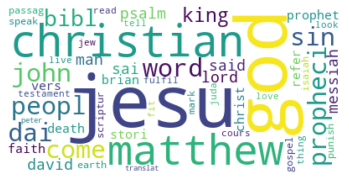

jesu god christian matthew peopl sin dai john word propheci come bibl king psalm david man sai messiah said lord prophet vers stori faith brian death christ refer passag mark earth gospel isaiah punish speak scriptur testament cours fulfil love fit read look live thing jew tell juda translat peter


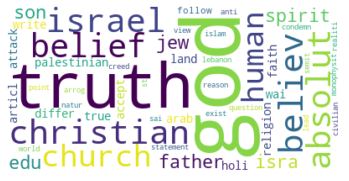

god truth christian israel believ absolut belief church human spirit jew father isra son edu palestinian arab differ land true religion write faith holi accept attack articl wai follow question exist anti point st sai realiti lebanon creed natur condemn lead reason semit civilian world statement arrog view monophysit islam


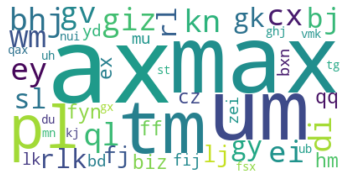

ax max um tm pl giz bhj ey wm kn ql di gv cx ei bj sl gy gk rl rlk fj lj fyn ex qq ff cz biz hm fij zei bxn lk mu bd yd ghj qax mn uh gx kj vmk du st nui ub tg fsx


In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
n_top_words = 50
for topic_idx, topic in enumerate(phi_z_w):
    data = " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    wordcloud = WordCloud(background_color = 'white').generate(data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print(data)

In [17]:
with open('sonnetsPreprocessed.txt', 'r') as f:
    sonnets = f.read().splitlines()

<h2> Sonnet </h2>

In [18]:
with open('sonnetsPreprocessed.txt', 'r') as f:
    sonnets = f.read().splitlines()

In [19]:
sonnetDF = pd.DataFrame(data = sonnets , columns = ["Text"])

In [20]:
transform_to_lower = lambda s: s.lower()
remove_emails = lambda s: re.sub(r'^[a-zA-Z0-9+_.-]+@[a-zA-Z0-9.-]+$', '', s)
remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s)

CLEAN_FILTERS = [
                remove_emails,
                strip_tags,
                strip_numeric,
                remove_emails,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords]

def cleaningPipe(document):
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words

def joinList(processed_words):
    return ' '.join(processed_words)

def basicStemming(text):
    return parsing.stem_text(text)

In [21]:
sonnetDF["cleanedText"] = sonnetDF["Text"].apply(cleaningPipe).apply(joinList).apply(basicStemming)

In [22]:
tf_vectorizer = CountVectorizer(stop_words='english')

In [23]:
tf = tf_vectorizer.fit_transform(sonnetDF["cleanedText"])

In [24]:
vocabulary = tf_vectorizer.vocabulary_

In [25]:
docs = []
for row in tf.toarray():
    present_words = np.where(row != 0)[0].tolist()
    present_words_with_count = []
    for word_idx in present_words:
        for count in range(row[word_idx]):
            present_words_with_count.append(word_idx)
    docs.append(present_words_with_count)

In [26]:
D = len(docs)        # number of documents
V = len(vocabulary)  # size of the vocabulary 
T = 20               # number of topics
iterations = 100   # number of iterations

alpha = 1 / T         # the parameter of the Dirichlet prior on the per-document topic distributions
beta = 1 / T        # the parameter of the Dirichlet prior on the per-topic word distribution

In [27]:
z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j
theta_d_z = np.zeros((D, T))
phi_z_w = np.zeros((T, V))
n_d = np.zeros((D))
n_z = np.zeros((T))

## Initialize the parameters
# m: doc id
for d, doc in enumerate(docs):
    # n: id of word inside document, w: id of the word globally
    for n, w in enumerate(doc):
        # assign a topic randomly to words
        z_d_n[d][n] = n % T
        # get the topic for word n in document m
        z = z_d_n[d][n]
        # keep track of our counts
        theta_d_z[d][z] += 1
        phi_z_w[z, w] += 1
        n_z[z] += 1
        n_d[d] += 1

for iteration in tqdm(range(iterations)):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word n in document m
            z = z_d_n[d][n]

            # decrement counts for word w with associated topic z
            theta_d_z[d][z] -= 1
            phi_z_w[z, w] -= 1
            n_z[z] -= 1

            # sample new topic from a multinomial according to our formula
            p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + T * alpha)
            p_t_w = (phi_z_w[:, w] + beta) / (n_z + V * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            new_z = np.random.multinomial(1, p_z).argmax()

            # set z as the new topic and increment counts
            z_d_n[d][n] = new_z
            theta_d_z[d][new_z] += 1
            phi_z_w[new_z, w] += 1
            n_z[new_z] += 1

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


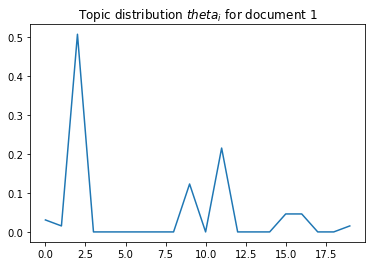

In [28]:
i = 1
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]));
plt.title("Topic distribution $theta_i$ for document {}".format(i));

In [29]:
phi_z_w.shape

(20, 2378)

In [30]:
inv_vocabulary = {v: k for k, v in vocabulary.items()}
n_top_words = 20
for topic_idx, topic in enumerate(phi_z_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: time beauti youth live ag awai doth seen look decai fear flower increas store like hour hath confound set dull
Topic #1: thy thou thee love art thine hast hate heart know self bear dost gentl grace wilt fault state best poor
Topic #2: thy thou thee doth time sweet self thine fair love beauti art dost live shall let prais worth natur old
Topic #3: time soul hour glass stai check suffer crime purpos rich pleasur thy nought slave account wait women larg wide hand
Topic #4: woe sorrow wilt let wound unkind ah kill night tyrant tast leav ransom soon moan leisur ist steel cross bosom
Topic #5: mortal save swift gone dear extrem plea spur excus weari know speed wast action earth wai sooner possess reason heavili
Topic #6: prais muse vers write pen fair invent number poet worth argument subject bring bless tomb dumb come forth sin ag
Topic #7: love ill sake loss death friend cure brand life hand thought prove bath buri sick desir sad heat came maiden
Topic #8: love thing ey true let 

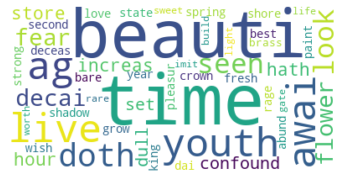

time beauti youth live ag awai doth seen look decai fear flower increas store like hour hath confound set dull spring rage bare year wish abund state shadow pleasur best fresh strong crown paint second deceas shore love dai grow king brass sweet rare light life worth build imit gate


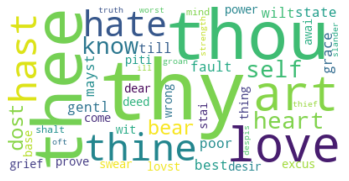

thy thou thee love art thine hast hate heart know self bear dost gentl grace wilt fault state best poor till mayst prove power wit grief swear come lovst wrong dear piti excus thing deed desir awai base stai shalt mind groan worst strength truth despis ill oft thief slander


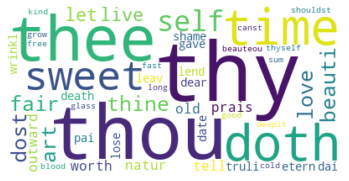

thy thou thee doth time sweet self thine fair love beauti art dost live shall let prais worth natur old tell outward shame lend leav etern death pai lose truli date wrinkl dear gave dai thyself long despit sum shouldst fast grow beauteou glass canst good blood free cold kind


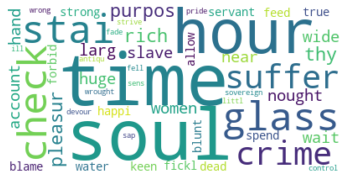

time soul hour glass stai check suffer crime purpos rich pleasur thy nought slave account wait women larg wide hand huge near happi forbid strong true water feed dead blunt keen spend servant blame allow fickl sovereign sens fell strive ill devour wrong wrought fade pride littl control sap antiqu


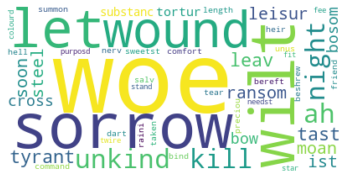

woe sorrow wilt let wound unkind ah kill night tyrant tast leav ransom soon moan leisur ist steel cross bosom bow tortur substanc length friend salv taken preciou tear summon dart beshrew unus nerv comfort raini command bind hell bereft heir sweetst purposd fit stand star twire fee needst colourd


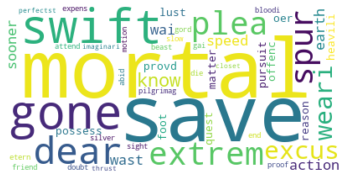

mortal save swift gone dear extrem plea spur excus weari know speed wast action earth wai sooner possess reason heavili oer provd pursuit offenc matter quest lust foot pilgrimag proof friend slow bloodi gai expens doubt motion beast end etern attend silver abid die sight gord perfectst thrust imaginari closet


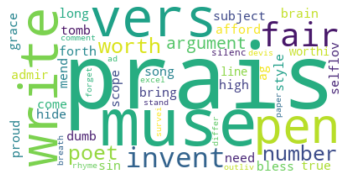

prais muse vers write pen fair invent number poet worth argument subject bring bless tomb dumb come forth sin ag brain grace need admir style high song afford proud scope hide selflov long true mend worthi line silenc comment ad stand outliv rhyme breath forget devis survei excel differ paper


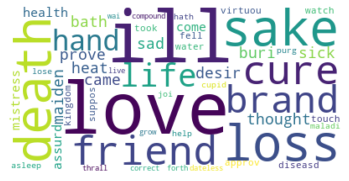

love ill sake loss death friend cure brand life hand thought prove bath buri sick desir sad heat came maiden health come mistress assurd approv suppos diseasd water virtuou took touch kingdom watch fell asleep lose cupid hath maladi joi purg help dateless wai grow correct forth compound live thrall


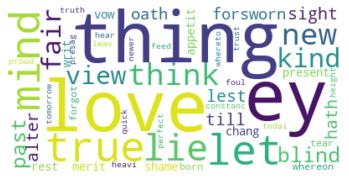

love thing ey true let mind lie think new kind fair view blind past sight lest till hath alter forsworn oath present appetit rest writ merit chang vow shame whereon forgot tear born constanc hear todai leav feed tomorrow heavi perfect truth foul presag whereto height proud newer quick trust


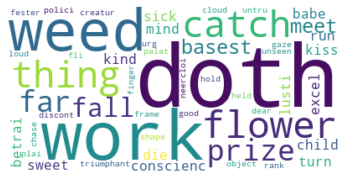

doth work weed flower thing catch prize far fall basest meet conscienc sick kind child turn sweet babe betrai mind run die kiss lusti excel triumphant rank creatur discont object urg fli gaze cloud frame dear polici plai shape chase good palat unseen fester hold finger held untru loud neercloi


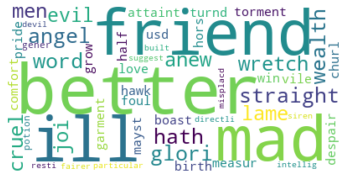

better friend mad ill straight angel wealth hath glori word wretch lame men cruel anew joi evil torment win love birth turnd garment boast vile hawk attaint mayst despair pride measur usd churl foul grow comfort hors half gener potion intellig resti fairer directli particular suggest misplacd built devil siren


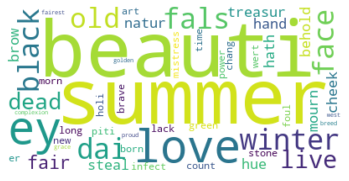

beauti summer ey love winter dai black fals face old live dead fair treasur natur steal hue hath cheek behold brow mourn hand green er piti long lack count morn stone mistress power art infect new born foul time brave holi wert chang complexion proud fairest grace west breed golden


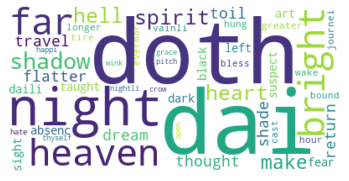

doth dai night heaven like far bright shadow spirit heart hell make thought travel flatter shade dream toil return taught suspect daili dark sight black art left fear absenc greater evermor cast longer wake vainli bless bound journei hung hour tire thyself hate nightli wink happi crow open grace pitch


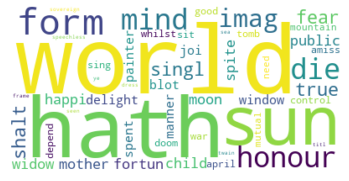

world hath sun form honour mind die imag singl true fear shalt public mother happi fortun spite moon widow child delight painter joi spent window blot manner april amiss whilst good depend control sing war sit tomb doom mountain mutual need sovereign speechless twain frame titl dress ye seen sea


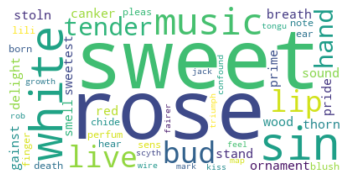

sweet rose sin white music lip bud live tender hand ornament breath stand stoln sweetest delight canker gainst wood sound red thorn pride prime smell perfum hear chide lili born note ear finger pleas blush sens death growth kiss wire feel tongu mark triumph jack scyth fairer map rob confound


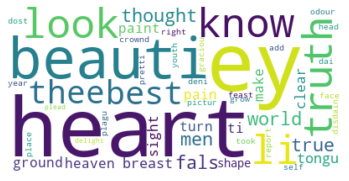

ey heart beauti look truth know li best thee thought world men fals true tongu breast ground paint pain sight heaven ti make turn clear shape pictur youth self right took odour crownd feast report face deni grow dost add place graciou pretti plagu disdain dai head year delight plead


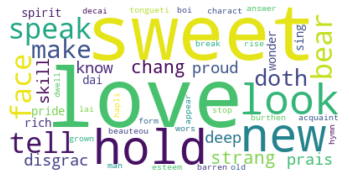

love sweet hold new look speak tell face bear make doth strang chang disgrac know prais skill proud deep spirit dai pride wonder rich sing tongueti acquaint boi grown charact shall break decai stop lai answer rise burthen form old man dwell barren wors esteem like beauteou appear hymn hapli


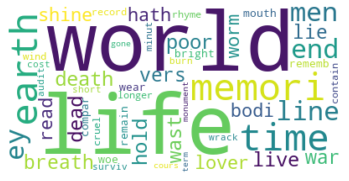

shall life world memori earth time line men end ey poor live death dead wast hold breath vers war lie lover shine bodi worm hath read bright compar rememb wear woe remain mouth longer wind minut record contain rhyme cruel surviv burn cost wrack short audit cours monument term gone


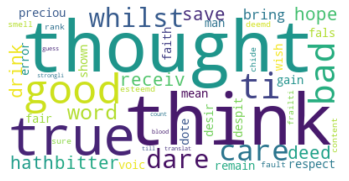

thought like think true good ti bad care whilst dare word bitter hope deed receiv save hath drink bring preciou mean respect man dote gain wish error remain fals despit shown faith desir voic fair esteemd deemd rank fault smell chide sure frailti content strongli till count guess translat blood


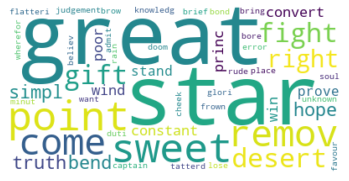

great star point sweet remov come fight gift desert right simpl truth hope bend constant convert princ wind win poor prove stand knowledg frown tatterd judgement place glori cheek wherefor captain brow brief bond unknown believ want flatteri minut doom soul error lose duti favour admit rain bring rude bore


In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
n_top_words = 50
for topic_idx, topic in enumerate(phi_z_w):
    data = " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    wordcloud = WordCloud(background_color = 'white').generate(data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print(data)